In [4]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import emcee

In [59]:
def roll(theta):
    theta1 = np.roll(theta, 1)
    theta2 = np.roll(theta, -1)
    return theta1, theta2

def pi(theta):
    theta1, _ = roll(theta)
    return np.sum(np.cos(theta-theta1))

def pih(xh, yt):
    return -np.log(pi(xh)) + k(yt)

k = lambda x: x**2 / 2

def logpi(theta, beta): # was actually dlogpi
    theta1, theta2 = roll(theta)
    return beta * (-np.sin(theta-theta1)-np.sin(theta-theta2))

def ode(xh, xt, h, gm):
    noise = npr.randn(L)
    xph = xt + h/2 * logpi(xt, beta)
    xpt = xh + h/2 * xph
    xppt = np.exp(-gm * h) * xpt + np.sqrt(1-np.exp(-2*gm*h))*noise
    x2h = xph + h/2 * xppt
    x2t = xppt + h/2 * logpi(x2h, beta)
    return x2h, x2t

def r(xh,xt,yh,yt,gm):
    v = np.exp(-gm*h) * logpi(xh,beta) + logpi(yh,beta) 
    vec = yt - np.exp(-gm*h)*xt - h/2 * v
    denom = np.linalg.norm(vec) ** 2
    return np.exp(-denom /2/(1-np.exp(-2*h*gm)))

def rec30(theta, h, beta, gm, rej = False):
    xh = npr.choice([-1,1], size=L)
    xt = npr.randn(L**2).reshape(L,L)
    y2h, y2t = ode(xh, xt, h, gm)
    if rej == False:
        xh = y2h
        return xh
    p = pih(y2h, y2t) / pih(xh, xt) * (r(y2h, -y2t, xh, -xt, gm) / r(xh, xt, y2h, y2t,gm))
    cond = npr.random() < p
    xh = cond * y2h + (1-cond) * xh
    return xh

def iter8(h, L, beta, gm, rej = False):
    theta = npr.uniform(-np.pi, np.pi, size=L)
    itermax = int(100/h)
    M = np.zeros(itermax)
    for i in range(itermax):
        theta = rec30(theta, h, beta, gm, rej=rej)
        M[i] = np.sum(np.cos(theta))
    return M

def get_iat(M):
    return emcee.autocorr.integrated_time(M, tol=0)[0]

In [60]:
L = 10
beta = 1/6
gm = .2
h0 = np.arange(.05, .16, .02)
res1 = np.zeros(6)
res2 = np.zeros(6)
for i in range(6):
    h = h0[i]
    M1 = iter8(h, L, gm, beta)
    M2 = iter8(h, L, gm, beta, rej=True)
    res1[i] = get_iat(M1)
    res2[i] = get_iat(M2)

C:\Users\zixia\AppData\Local\Temp\ipykernel_18092\3844591629.py:11: RuntimeWarning: invalid value encountered in log
  return -np.log(pi(xh)) + k(yt)
C:\Users\zixia\AppData\Local\Temp\ipykernel_18092\3844591629.py:41: RuntimeWarning: invalid value encountered in double_scalars
  p = pih(y2h, y2t) / pih(xh, xt) * (r(y2h, -y2t, xh, -xt, gm) / r(xh, xt, y2h, y2t,gm))


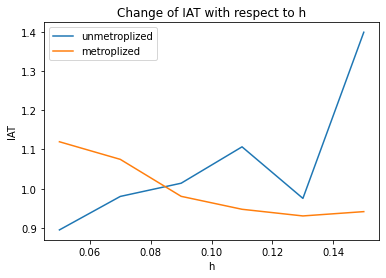

In [30]:
plt.plot(h0, res1, label="unmetroplized")
plt.plot(h0, res2, label="metroplized")
plt.xlabel("h")
plt.ylabel("IAT")
plt.title("Change of IAT with respect to h")
plt.legend()
plt.show()

In [19]:
L = 10
beta = 1/6
gm0 = np.arange(.2, .5, .05)
h = .05
res3 = np.zeros(6)
res4 = np.zeros(6)
for i in range(6):
    gm = gm0[i]
    M3 = iter8(h, L, gm, beta)
    M4 = iter8(h, L, gm, beta, rej=True)
    res3[i] = get_iat(M3)
    res4[i] = get_iat(M4)

C:\Users\zixia\AppData\Local\Temp\ipykernel_18092\3149058935.py:11: RuntimeWarning: invalid value encountered in log
  return -np.log(pi(xh)) + k(yt)


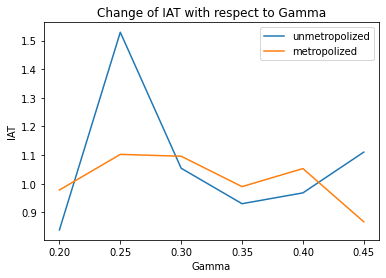

In [20]:
plt.plot(gm0, res3, label="unmetropolized")
plt.plot(gm0, res4, label="metropolized")
plt.xlabel("Gamma")
plt.ylabel("IAT")
plt.title("Change of IAT with respect to Gamma")
plt.legend()
plt.show()